# 0 環境構築

In [1]:
!git clone https://github.com/EliSchwartz/imagenet-sample-images.git

Cloning into 'imagenet-sample-images'...
remote: Enumerating objects: 1012, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1012 (delta 3), reused 5 (delta 2), pack-reused 1002
Receiving objects: 100% (1012/1012), 103.84 MiB | 28.23 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchinfo

# 1 画像のPathとLabelの抽出

In [4]:
image_path_list = sorted(glob.glob("/content/imagenet-sample-images/*.JPEG"))
image_path_list[:10]

['/content/imagenet-sample-images/n01440764_tench.JPEG',
 '/content/imagenet-sample-images/n01443537_goldfish.JPEG',
 '/content/imagenet-sample-images/n01484850_great_white_shark.JPEG',
 '/content/imagenet-sample-images/n01491361_tiger_shark.JPEG',
 '/content/imagenet-sample-images/n01494475_hammerhead.JPEG',
 '/content/imagenet-sample-images/n01496331_electric_ray.JPEG',
 '/content/imagenet-sample-images/n01498041_stingray.JPEG',
 '/content/imagenet-sample-images/n01514668_cock.JPEG',
 '/content/imagenet-sample-images/n01514859_hen.JPEG',
 '/content/imagenet-sample-images/n01518878_ostrich.JPEG']

In [5]:
def label_name_extract(image_path, target):
  image_path_basename = os.path.basename(image_path)
  image_path_no_extension = os.path.splitext(image_path_basename)[0]
  idx = image_path_no_extension.find(target)
  label_name = image_path_no_extension[idx+1:]
  return label_name

In [6]:
target = '_'
label_name_list = [label_name_extract(image_path, target) for image_path in image_path_list]
label_name_list[:10]

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

# 2 ImageNetのデータセット

In [7]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor(),
 transforms.Normalize(
 mean=IMAGENET_MEAN,
 std=IMAGENET_STD
 )])


In [8]:
class ImageNetDataset(Dataset):
    def __init__(self, image_path_list, label_name_list, transform=None):

      self.image_path_list = image_path_list
      self.label_name_list = label_name_list
      self.transform = transform

    def __len__(self):

      return len(self.label_name_list)

    def __getitem__(self, idx):

      image_open = Image.open(image_path_list[idx]).convert("RGB")
      label_name = self.label_name_list[idx]
      if self.transform:
          image = self.transform(image_open)

      return image, label_name

In [9]:
dataset = ImageNetDataset(image_path_list, label_name_list, transform=transform)

In [10]:
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [11]:
image_tensor, labels = next(iter(dataloader))

In [12]:
image_tensor.shape

torch.Size([10, 3, 224, 224])

In [13]:
labels

('traffic_light',
 'plate_rack',
 'dome',
 'harp',
 'Arabian_camel',
 'French_bulldog',
 'menu',
 'feather_boa',
 'bonnet',
 'paintbrush')

# 3 Vision Transformer


In [14]:
model = models.vit_b_16(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [15]:
image_tensor.shape

torch.Size([10, 3, 224, 224])

In [16]:
torchinfo.summary(model, image_tensor.shape, depth=2)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [10, 1000]                768
├─Conv2d: 1-1                                 [10, 768, 14, 14]         590,592
├─Encoder: 1-2                                [10, 197, 768]            151,296
│    └─Dropout: 2-1                           [10, 197, 768]            --
│    └─Sequential: 2-2                        [10, 197, 768]            85,054,464
│    └─LayerNorm: 2-3                         [10, 197, 768]            1,536
├─Sequential: 1-3                             [10, 1000]                --
│    └─Linear: 2-4                            [10, 1000]                769,000
Total params: 86,567,656
Trainable params: 86,567,656
Non-trainable params: 0
Total mult-adds (G): 1.73
Input size (MB): 6.02
Forward/backward pass size (MB): 1040.94
Params size (MB): 232.27
Estimated Total Size (MB): 1279.22

In [17]:
torchinfo.summary(model, image_tensor.shape, depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [10, 1000]                768
├─Conv2d: 1-1                                 [10, 768, 14, 14]         590,592
├─Encoder: 1-2                                [10, 197, 768]            151,296
│    └─Dropout: 2-1                           [10, 197, 768]            --
│    └─Sequential: 2-2                        [10, 197, 768]            --
│    │    └─EncoderBlock: 3-1                 [10, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-2                 [10, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-3                 [10, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-4                 [10, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-5                 [10, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-6                 [10, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-7             

In [18]:
torchinfo.summary(model, image_tensor.shape, depth=5)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [10, 1000]                768
├─Conv2d: 1-1                                 [10, 768, 14, 14]         590,592
├─Encoder: 1-2                                [10, 197, 768]            151,296
│    └─Dropout: 2-1                           [10, 197, 768]            --
│    └─Sequential: 2-2                        [10, 197, 768]            --
│    │    └─EncoderBlock: 3-1                 [10, 197, 768]            --
│    │    │    └─LayerNorm: 4-1               [10, 197, 768]            1,536
│    │    │    └─MultiheadAttention: 4-2      [10, 197, 768]            2,362,368
│    │    │    └─Dropout: 4-3                 [10, 197, 768]            --
│    │    │    └─LayerNorm: 4-4               [10, 197, 768]            1,536
│    │    │    └─MLPBlock: 4-5                [10, 197, 768]            --
│    │    │    │    └─Linear: 5-1             [10, 197, 3072]          

In [19]:
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

# 4 モデルの出力

In [20]:
model.eval()

output = model(image_tensor)
print(output.shape)
print(output.argmax(axis=1))

predict = [label_name_list[label] for label in output.argmax(axis=1)]
print(labels)
print(predict)

torch.Size([10, 1000])
tensor([920, 729, 538, 594, 354, 245, 922, 552, 452, 696])
('traffic_light', 'plate_rack', 'dome', 'harp', 'Arabian_camel', 'French_bulldog', 'menu', 'feather_boa', 'bonnet', 'paintbrush')
['traffic_light', 'plate_rack', 'dome', 'harp', 'Arabian_camel', 'French_bulldog', 'menu', 'feather_boa', 'bonnet', 'paintbrush']


# 5 画像と予測の確認

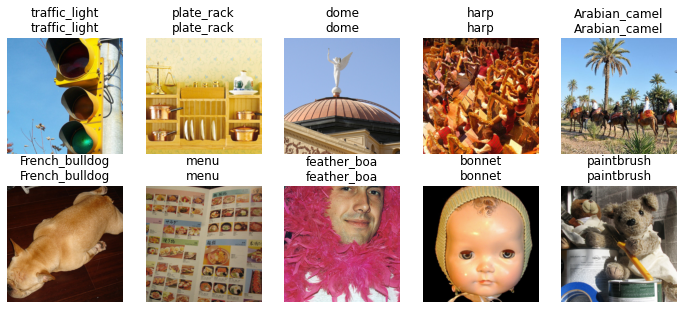

In [21]:
image_n = 10
row = 2
col = 5

plt.figure(figsize=(12, 5))

for i in range(image_n):
  
  x = image_tensor[i].to('cpu').mul(torch.FloatTensor(IMAGENET_STD).view(3, 1, 1))
  x = x.add(torch.FloatTensor(IMAGENET_MEAN).view(3, 1, 1)).detach().numpy()
  plt.subplot(row, col, i+1)
  plt.imshow(x.transpose(1, 2, 0))
  plt.axis('off')
  plt.title(labels[i]+"\n"+predict[i])